<a href="https://colab.research.google.com/github/Asciotti/neural-sar/blob/master/notebooks/2-train_upsized_network_stages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment training in stages w/ freezing layers to upsized images using models generated from [first notebook](https://github.com/Asciotti/neural-sar/blob/master/notebooks/1_simple_autoencoder.ipynb)

Ref [Generating High Quality Visible Images from SAR Images Using CNNs](https://arxiv.org/abs/1802.10036) by Puyang Wang & Vishal M. Patel

## Notes

Network as designed and trained in [part 1](https://github.com/Asciotti/neural-sar/blob/master/notebooks/1_simple_autoencoder.ipynb) will be imported into this and increasing large image sizes will be trained in stages. As larger images are inputted into the network, an additional beginning and end convolutional layer will be added which will downscale the image to the previously trained model's input size.

## Data Sources

~3k [High Resolution Orthoimages](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-aerial-photography-high-resolution-orthoimagery-hro?qt-science_center_objects=0#qt-science_center_objects) manually downloaded from https://earthexplorer.usgs.gov/ 

Images should have 0.25 foot resolution and originally 10kx10k pixels downsized to 512x512 pixels locally then finally downsized to 256x256 pixels for initial experimentation.

## Network Architecture

Below is the encoder-decoder network leveraging skip connections that is being utilized. Note, in my implementation the input and output data set is slightly different. There is no "despeckle" component to the network. Also note, due to VRAM constraints on Google Collab, the number of filters in each Conv layer is halved.

![](https://github.com/Asciotti/neural-sar/blob/master/notebooks/resources/autoencoder.PNG?raw=1)

### Changelog

9/19 - Noticed that tanh from previous 256x256 network was still there, removed  
9/19 - Added skip connection from beginning 512 Conv2D to last 512 Conv2D  
9/20 - Fixed time stamps, as time.local() calls local for the server which can change, explicility set it to Eastern timezone  

In [7]:
# I currently store my data on google drive, but it is stored in the repo under 
# https://github.com/Asciotti/neural-sar/tree/master/notebooks/data
# google drive also lets us store off trained models
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%%capture
!pip install ipdb

## Imports

In [0]:
from datetime import datetime
from pytz import timezone
import numpy as np
import glob
import re
# Matplotlib
import matplotlib.pyplot as plt
plt.rcParams['lines.linewidth'] = 4
plt.style.use(['seaborn-dark'])
# Image 
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.exposure import histogram
# Keras
import keras
from keras.layers import  Input,Conv2D,Conv2DTranspose, BatchNormalization,Activation,Subtract,Add
from keras.models import Model, load_model, Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam
from keras.callbacks import *

### Helper functions to load and process data

Note: The images are **NOT** resized, they will be left as (512,512) px and will only be training an added head and tail of the network in this portion.

In [0]:
def get_image(name):
    
    img = imread('/content/drive/My Drive/Colab Notebooks/1_ft_ortho_images/'  + str(int(name)) + '.png', as_gray=False)
    # Rescale to [0,1]
    if np.max(img) > 1:
      img = img/255.0
    
    return(img)

In [0]:
def image_generator(indices,batch_size = 32):
    
    while True:
          # Select files (paths/indices) for the batch
          batch_paths = np.random.choice(a = indices, 
                                         size = batch_size)
          batch_input = []
          batch_output = [] 
          # Read in each input, make in/truth images
          for input_path in batch_paths:
              # Get raw RBG image
              image = get_image(input_path)
              # Extract out RBG and Grayscale images
              input = resize(rgb2gray(image), (512,512,1))
              output = image
              batch_input += [ input ]
              batch_output += [ output ]
          # Return a tuple of (input,output) to feed the network
          batch_x = np.array( batch_input )
          batch_y = np.array( batch_output )
        
          yield( batch_x, batch_y )

(1, 512, 512, 1)
(1, 512, 512, 3)


Text(0.5, 1.0, 'Color')

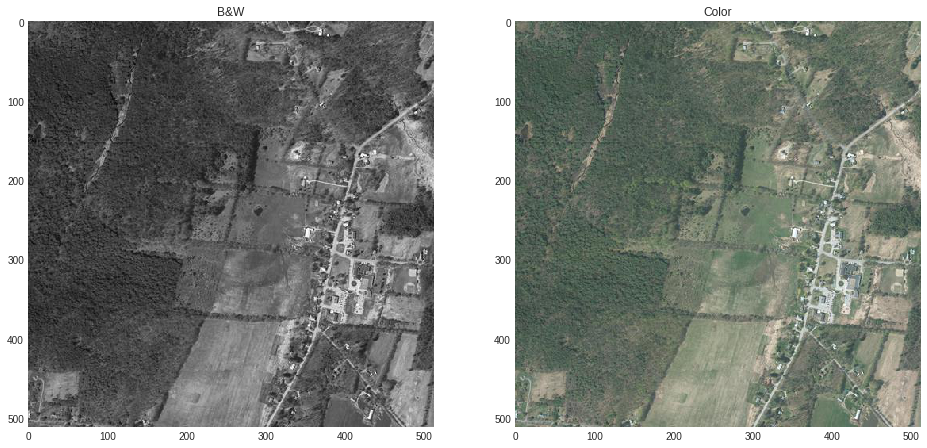

In [57]:
# Test generator & loader
im_gen = image_generator([68], 1)
X_img, y_truth = im_gen.__next__()
print(X_img.shape)
print(y_truth.shape)
fig, axes = plt.subplots(1,2,figsize=(16,16))
axes[0].imshow(X_img.reshape(512,512), cmap='gray')
axes[0].set_title('B&W')
axes[1].imshow(y_truth.reshape(512,512,3))
axes[1].set_title('Color')

### Helper functions for model training and display

In [0]:
class NBatchLogger(Callback):
    """
    A Logger that log average performance per `display` steps.
    """
    def __init__(self, display):
        self.epoch = 0
        self.display = display
        self.metric_cache = {}

    def on_epoch_begin(self, epoch, logs={}):
        for k in self.params['metrics']:
            if k in logs:
                self.metric_cache[k] = self.metric_cache.get(k, 0) + logs[k]
        if self.epoch % self.display == 0:
            metrics_log = ''
            for (k, v) in self.metric_cache.items():
                val = v / self.display
                if abs(val) > 1e-3:
                    metrics_log += ' - %s: %.4f' % (k, val)
                else:
                    metrics_log += ' - %s: %.4e' % (k, val)
            print('Epoch: [{}/{}] ... {}'.format(self.epoch,
                                          self.params['epochs'],
                                          metrics_log))
            self.metric_cache.clear()
        self.epoch += 1

def findLastCheckpoint(save_dir):
    file_list = glob.glob(os.path.join(save_dir,'*model*.hdf5'))  # get name list of all .hdf5 files
    if file_list:
        epochs_exist = []
        for file_ in file_list:
            result = re.search(r'\d{8}_\d{6}', file_)
            if result:
                epochs_exist.append((int(result.group()), file_))
        latest_epoch=max(epochs_exist)   
    else:
        latest_epoch = (None, None)
    return latest_epoch[-1]

## Load latest model (assuming latest model is best one so far)

In [0]:
%%capture
load_model = 1

if load_model:
    latest_model = findLastCheckpoint('/content/drive/My Drive/MyCNN/1-simple_autoencoder_models/')
    model = keras.models.load_model(latest_model)
else:
    model = model

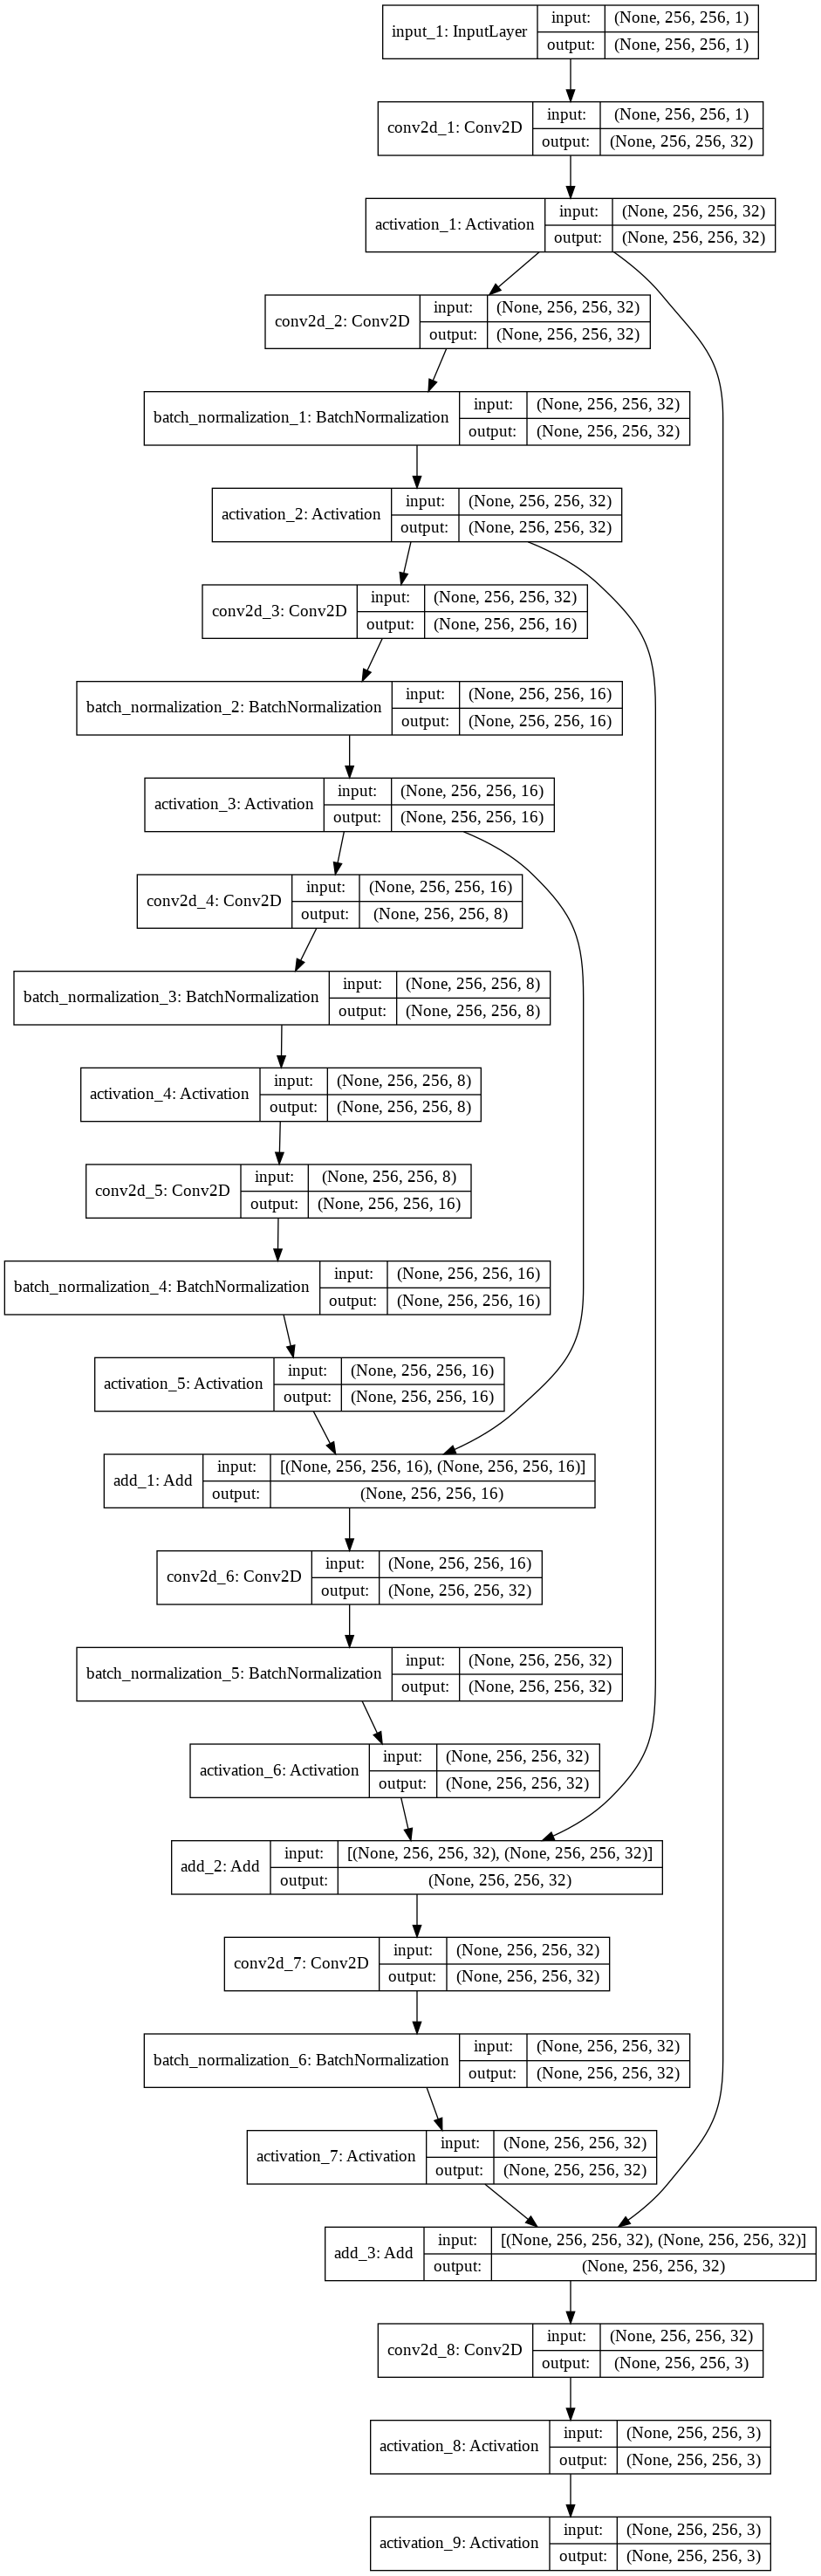

In [27]:
keras.utils.plot_model(model, show_shapes=True)

## Add a new head and tail to the pre-trained model to account for the upscaled input and truth images

In [0]:
# Make imported model not trainable
for layer in model.layers:
    layer.trainable=False

In [29]:
# Verify that layers are no longer trainable
[print('Layer {} trainable: {}'.format(i,layer.trainable)) for i, layer in enumerate(model.layers)];

Layer 0 trainable: False
Layer 1 trainable: False
Layer 2 trainable: False
Layer 3 trainable: False
Layer 4 trainable: False
Layer 5 trainable: False
Layer 6 trainable: False
Layer 7 trainable: False
Layer 8 trainable: False
Layer 9 trainable: False
Layer 10 trainable: False
Layer 11 trainable: False
Layer 12 trainable: False
Layer 13 trainable: False
Layer 14 trainable: False
Layer 15 trainable: False
Layer 16 trainable: False
Layer 17 trainable: False
Layer 18 trainable: False
Layer 19 trainable: False
Layer 20 trainable: False
Layer 21 trainable: False
Layer 22 trainable: False
Layer 23 trainable: False
Layer 24 trainable: False
Layer 25 trainable: False
Layer 26 trainable: False


In [0]:
# pop off last layer aka the tanh layer
# model.layers.pop()
# Change input shape to 512,512
inpt = Input(shape=(512,512,1))
# First increase to 512x512x32 similar to in the original architecture
lyr = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same', name='conv2d_up512')(inpt)
lyr = Activation('relu', name='activation_up512')(lyr)
# Save a skip layer
_skip0 = lyr
# Then downscale to 256x256x1 so that it can fit into the top most conv2d of the
# first trained model
lyr = Conv2D(filters=1, kernel_size=(3,3), strides=(2,2), padding='same', name='conv2d_down256')(lyr)
lyr = Activation('relu', name='activation_down256')(lyr)
# Start with the second layer, aka the conv2d of the original model
lyr = model.layers[1](lyr) 
for i in range(2, len(model.layers)):
    # first make layer not trainable
    # If last layer, ignore we are replacing
    if i >= len(model.layers)-3:
        continue
    # Save first skip
    if i == 3:
        _skip1 = lyr
    # Save second skip
    elif i == 6:
        _skip2 = lyr
    # Save third skip
    elif i == 9:
        _skip3 = lyr
    
    # Add first skip to third add
    if i == 23:
        lyr = model.layers[i]([lyr, _skip1])
    # Add second skip to second add
    elif i == 19:
        lyr = model.layers[i]([lyr, _skip2])
    # Add third skip to first add
    elif i == 15:
        lyr = model.layers[i]([lyr, _skip3])
    # Else, just do as normal
    else:
        lyr = model.layers[i](lyr)

# Upscale to target of 512x512x3
lyr = Conv2DTranspose(filters=32, kernel_size=(3,3), strides=(2,2), padding='same', name='conv2dtran_up512_atend')(lyr)
# Appears to be some size issues with shape inference
# fixed in https://github.com/tensorflow/tensorflow/pull/13193
lyr.set_shape((None, 512, 512,32))
lyr = BatchNormalization(axis=3, epsilon=0.0001,name='BNtran_up512_at_end')(lyr)
lyr = Activation('relu', name='activationtran_up512_at_end')(lyr)
# Add original 512x512 image link
lyr = Add(name='addtran_up512_at_end')([lyr, _skip0])
# 
lyr = Conv2D(filters=3, kernel_size=(3,3), strides=(1,1), padding='same', name='conv2d_up512_atend')(lyr)
lyr = Activation('relu', name='activation_up512_at_end')(lyr)
# Add output from [0.0,1.0]
lyr = Activation('tanh', name='output')(lyr)



stacked_model = Model(inpt, lyr)

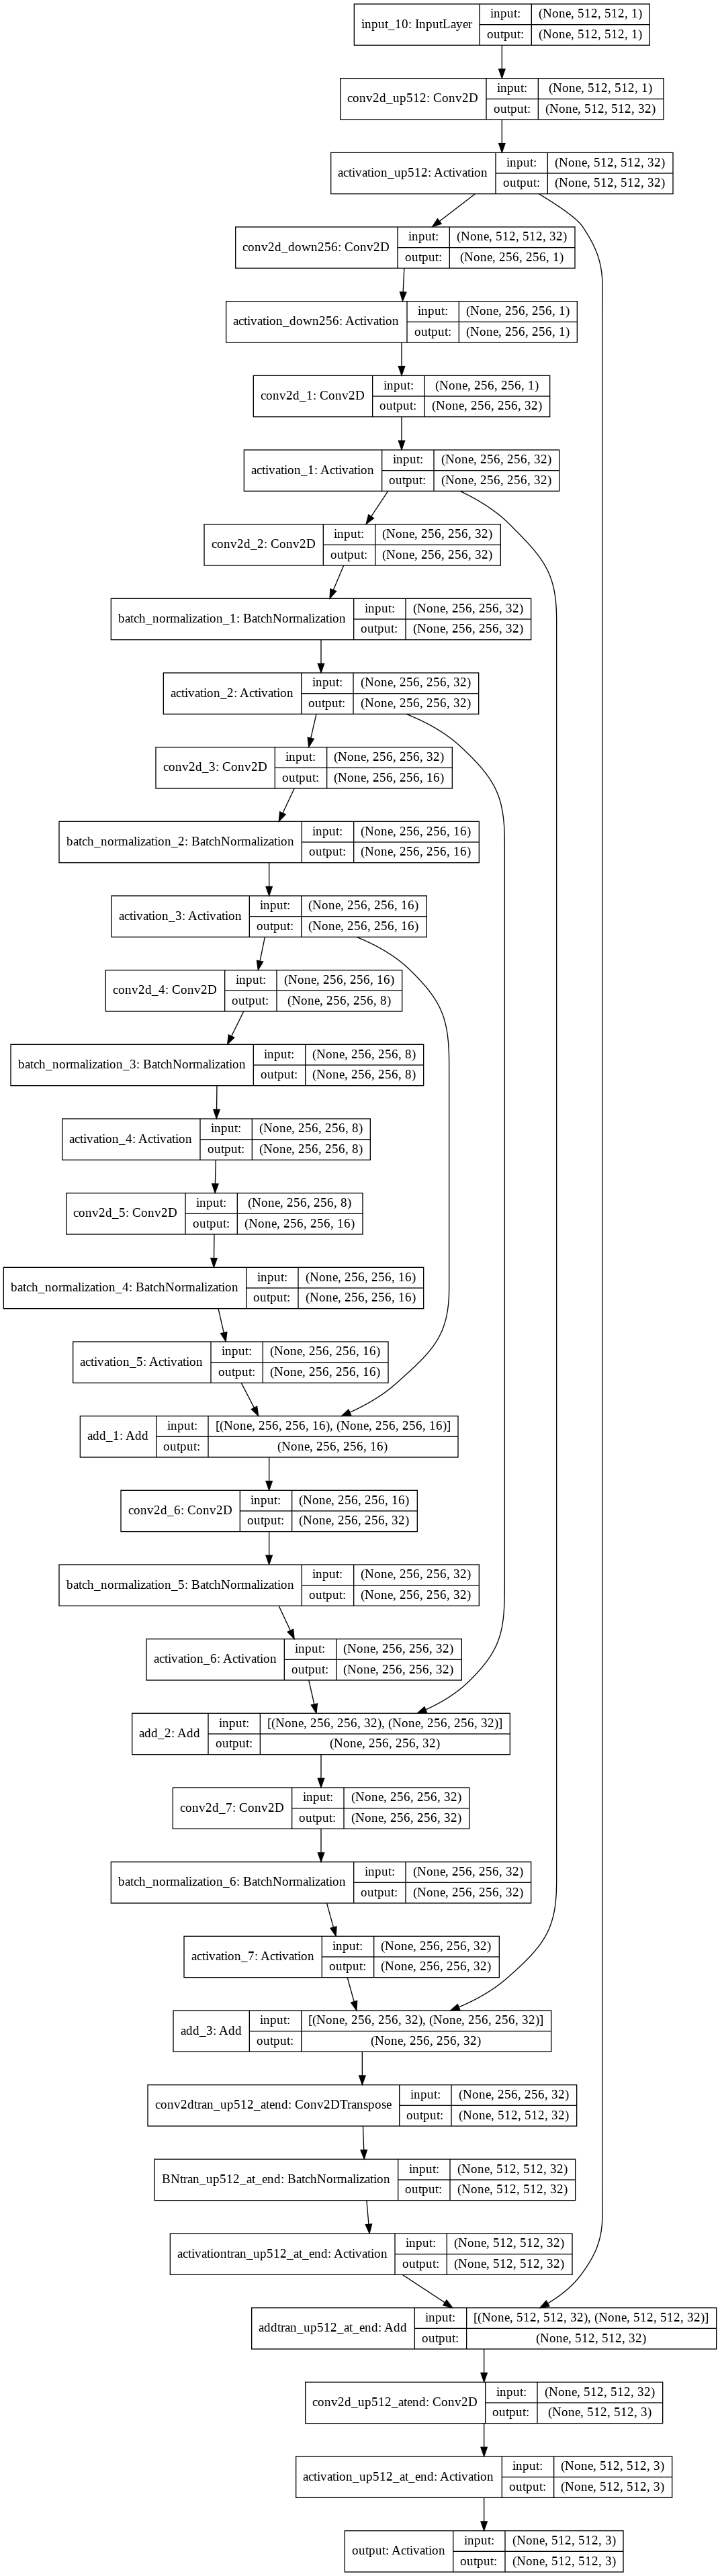

In [45]:
keras.utils.plot_model(stacked_model, show_shapes=True)

In [46]:
# Verify that the original layers are not trainable still
[print('Layer {} trainable: {}'.format(i,layer.trainable)) for i, layer in enumerate(stacked_model.layers)];

Layer 0 trainable: False
Layer 1 trainable: True
Layer 2 trainable: True
Layer 3 trainable: True
Layer 4 trainable: True
Layer 5 trainable: False
Layer 6 trainable: False
Layer 7 trainable: False
Layer 8 trainable: False
Layer 9 trainable: False
Layer 10 trainable: False
Layer 11 trainable: False
Layer 12 trainable: False
Layer 13 trainable: False
Layer 14 trainable: False
Layer 15 trainable: False
Layer 16 trainable: False
Layer 17 trainable: False
Layer 18 trainable: False
Layer 19 trainable: False
Layer 20 trainable: False
Layer 21 trainable: False
Layer 22 trainable: False
Layer 23 trainable: False
Layer 24 trainable: False
Layer 25 trainable: False
Layer 26 trainable: False
Layer 27 trainable: False
Layer 28 trainable: True
Layer 29 trainable: True
Layer 30 trainable: True
Layer 31 trainable: True
Layer 32 trainable: True
Layer 33 trainable: True
Layer 34 trainable: True


### Train the model

In [0]:
# Set number of images you want to train on, takes a while so starting w/ roughly 1/3 of data set
ind = range(1,1000)
# Set epochs
epochs = 20
# Set batch size
batch_size=16
# Set steps_per_epoch
steps_per_epoch = np.ceil(len(ind)/batch_size)
  # Total number of steps (batches of samples) to yield from generator before 
  # declaring one epoch finished and starting the next epoch. 
  # It should typically be equal to the number of unique samples of your 
  # dataset divided by the batch size.

In [50]:
# Get current time so each trained model is timestamped
# Recommended to leave this as one cell so you never forget to rerun the new time
fmt = "%Y%m%d_%H%M%S"
now_time = datetime.now(timezone('US/Eastern'))
t_now = now_time.strftime(fmt)
# Make Keras ModelCheckpoint to save off trained model at intervals
filepath="/content/drive/My Drive/MyCNN/2-train_upsized_network_stages/" + t_now + "_model-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_weights_only=False,save_best_only=True)

stacked_model.compile(optimizer=Adam(0.001), loss='mse')
history = stacked_model.fit_generator(image_generator(ind, batch_size), steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=0,\
                             callbacks=[checkpoint, NBatchLogger(5)])
json.dump(history.history, open("/content/drive/My Drive/MyCNN/2-train_upsized_network_stages/" + t_now + "_history.json", 'w'))

Epoch: [0/20] ... 
Epoch: [5/20] ... 
Epoch: [10/20] ... 
Epoch: [15/20] ... 


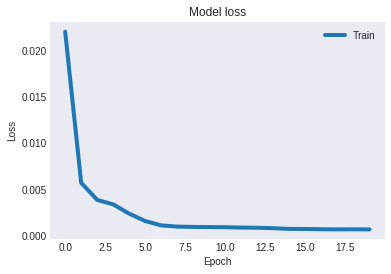

In [51]:
# Plot model loss over time
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [59]:
json.load(open('/content/drive/My Drive/MyCNN/2-train_upsized_network_stages/20190920_015501_history.json','r'))

{'loss': [0.02204623662437948,
  0.005711616327365239,
  0.003862820336565612,
  0.0033792761110124133,
  0.002369890457004427,
  0.0015777160897703162,
  0.0011028654490863638,
  0.000977099314147222,
  0.000938651146411541,
  0.0009222351807347011,
  0.0009065554754453755,
  0.000873098098155525,
  0.0008478308002287079,
  0.000804888023551376,
  0.0007246489570076976,
  0.0007163009621084682,
  0.0006907233499020101,
  0.0006745880153695387,
  0.0006839472787558205,
  0.0006705534067891893]}

### Using trained model, predict output on un-used image (also might need to load past trained model

In [0]:
# %%capture
load_model = 1

if load_model:
#     import ipdb; ipdb.set_trace()
    latest_model = findLastCheckpoint('/content/drive/My Drive/MyCNN/2-train_upsized_network_stages/')
    model = keras.models.load_model(latest_model)
else:
    model = model

In [0]:
# Get last image since we didn't use for testing, and feed forward through model
X_test, y_test = image_generator([2999, 3000], 2).__next__()
y_predict = model.predict(X_test)

X_test = X_test.reshape((2,512,512))
y_predict = y_predict.reshape((2,512,512,3))
y_test = y_test.reshape((2,512,512,3))

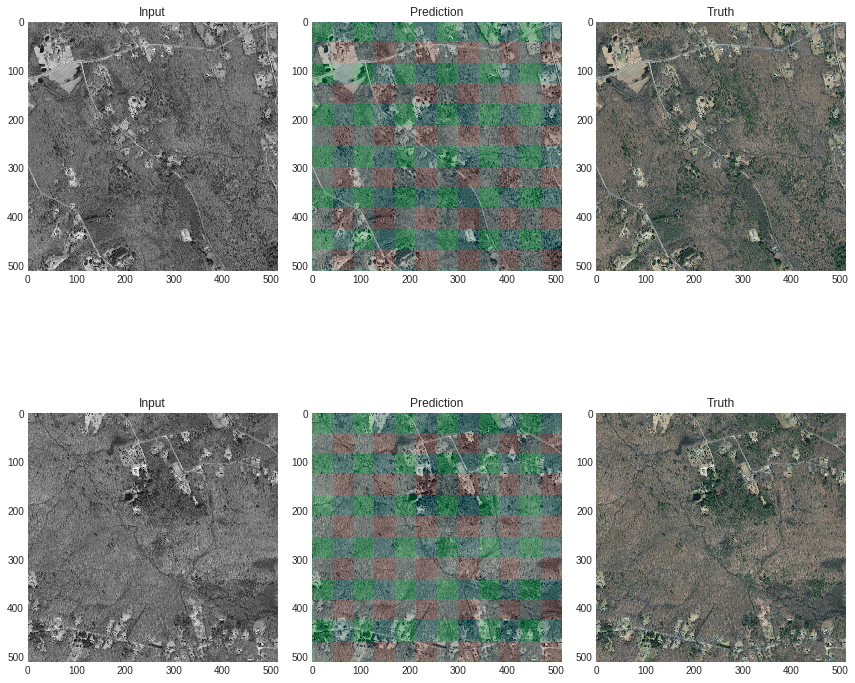

In [63]:
# Make figures
fig, axes = plt.subplots(2,3,figsize=(12,12))
for raxes in range(2):
    _in = X_test[raxes, ...]
    _pred = y_predict[raxes, ...]
    _truth = y_test[raxes, ...]
    axes[raxes, 0].imshow(_in, cmap='gray')
    axes[raxes, 0].set_title('Input')
    axes[raxes, 1].imshow(_pred)
    axes[raxes, 1].set_title('Prediction')
    axes[raxes, 2].imshow(_truth)
    axes[raxes, 2].set_title('Truth')

fig.tight_layout()  

### Analyze difference between predicted image and ground truth image

[9/19; 20190920_015501_model-20.hdf5] - Results have strange rectangular pattern that is dominated by one of the channels

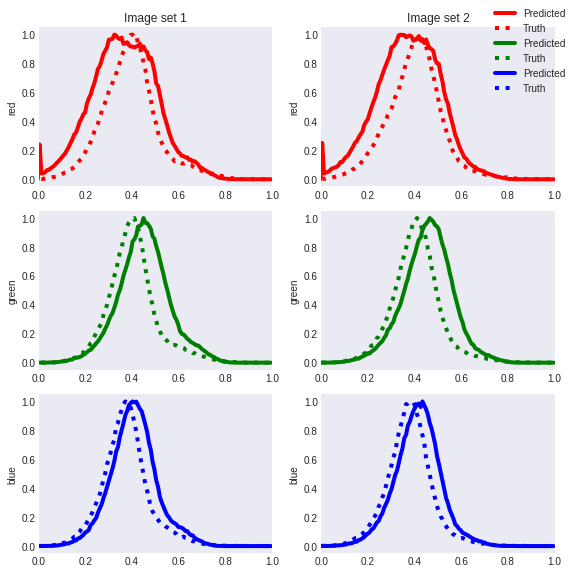

In [64]:
fig, axes = plt.subplots(3,2,figsize=(8,8))
for pred_num in range(2):
    for i, img in enumerate((y_predict, y_test)):
        for c, c_color in enumerate(('red', 'green', 'blue')):
            _pred = img[pred_num, ...]
            img_hist, bins = histogram(_pred[..., c], source_range='dtype')
            line_type = ':' if i == 1 else '-'
            label = 'Predicted' if i == 0 else 'Truth'
            # Only put labels on one set or else it looks annoying
            if pred_num == 0:
                axes[c, pred_num].plot(bins, img_hist / img_hist.max(), linestyle=line_type, color=c_color, label=label)
            else:
                axes[c, pred_num].plot(bins, img_hist / img_hist.max(), linestyle=line_type, color=c_color)
            axes[c, pred_num].set_ylabel(c_color)
            axes[c, pred_num].set_xlim([0, 1])

axes[0,0].set_title('Image set 1')
axes[0,1].set_title('Image set 2')
fig.legend()
fig.tight_layout()